# 🚨 Project 1: Cyberbullying Detection

🧾**Description:** This dataset is a collection of datasets from different sources related to the automatic detection of cyber-bullying. The data is from different social media platforms like Kaggle, Twitter, Wikipedia Talk pages, and YouTube. The data contains text and are labeled as bullying or not. The data contains different types of cyber-bullying like hate speech, aggression, insults, and toxicity. You have been provided with the twitter\_parsed tweets dataset, wherein you have to classify whether the tweet is toxic or not.

source of dataset & data dictionary - https://www.kaggle.com/code/sndpkirwai/cyberbully-detection-text-classification/data

🧭 **Problem Statement:** You are provided with **twitter\_parsed\_tweets**: you have to perform a step-by-step NLP approach to identify the toxicity of the tweet, and classify the tweet in a binary value. 

The target variable is **oh-label** and the evaluation metric is **F1-score**.

In [1]:
# dependencies
import re
import string
import pandas as pd
#import tweepy
import json
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from time import time

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.externals 
import joblib

In [2]:
# read in the csv file of labeled tweet ids
df = pd.read_csv('twitter_parsed_dataset.csv') 

df.head()

,index,id,Text,Annotation,oh_label
0,5.74948705591165E+017,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,5.75596338802373E+017,#mkr No No No No No No,none,0.0


In [4]:
df.shape

(16851, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16851 entries, 0 to 16850
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       16851 non-null  object 
 1   id          16850 non-null  object 
 2   Text        16850 non-null  object 
 3   Annotation  16848 non-null  object 
 4   oh_label    16848 non-null  float64
dtypes: float64(1), object(4)
memory usage: 658.4+ KB


In [9]:
df['Text'] = df['Text'].astype(str)

In [11]:
# Checking for NULL values 
df.isnull().sum()

index         0
id            1
Text          0
Annotation    3
oh_label      3
dtype: int64

In [13]:
# Since very few rows have null values, we can safely drop them
df = df.dropna()

In [14]:
df.isnull().sum()

index         0
id            0
Text          0
Annotation    0
oh_label      0
dtype: int64

In [15]:
#Check if columns index n id are identical/redundant
df['index'].equals(df['id'])

True

In [16]:
#Dropping column index as its identical wth id
df = df.drop(['index'], axis = 1)
df

,id,Text,Annotation,oh_label
0,5.74948705591165E+017,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,5.71917888690393E+017,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,3.90255841338601E+017,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,5.68208850655916E+017,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,5.75596338802373E+017,#mkr No No No No No No,none,0.0
...,...,...,...,...
16846,5.75606766236475E+017,"Feeling so sorry for the girls, they should be...",none,0.0
16847,5.72333822886326E+017,#MKR 'pretty good dishes we're happy with' - O...,none,0.0
16848,5.72326950057845E+017,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0
16849,5.74799612642357E+017,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0


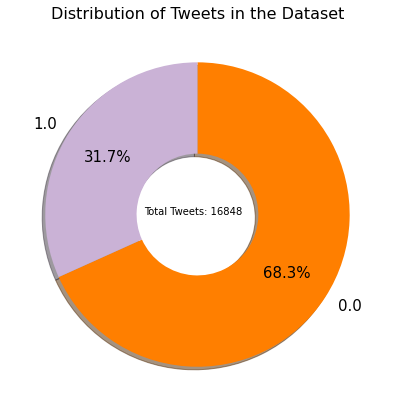

In [17]:
# Target Value distribution
plt.figure(figsize = (7,7))
sorted_counts = df['oh_label'].value_counts()
plt.pie(sorted_counts, labels = sorted_counts.index, startangle = 90, counterclock = False, wedgeprops = {'width' : 0.6},
       autopct='%1.1f%%', pctdistance = 0.7, textprops = {'color': 'black', 'fontsize' : 15}, shadow = True,
        colors = sns.color_palette("Paired")[7:])
plt.text(x = -0.35, y = 0, s = 'Total Tweets: {}'.format(df.shape[0]))
plt.title('Distribution of Tweets in the Dataset', fontsize = 16);

<AxesSubplot:>

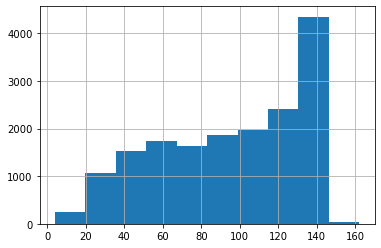

In [18]:
df['Text'].str.len().hist()

In [19]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F" #emoticons
                u"\U0001F300-\U0001F5FF" #symbols & pictograms
                u"\U0001F680-\U0001F6FF" #transport & map symbols
                u"\U0001F1E0-\U0001F1FF" #flags(ios)
                u"\U00002702-\U000027B0"
                u"\U000024C2-\U0001F251" 
                "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    delete_dict = {sp_character: '' for sp_character in string.punctuation}
    delete_dict[' '] = ' '
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr = text1.split()
    text2 = ' '.join([w for w in textArr if(not w.isdigit() and (not w.isdigit() and len(w) > 3))])

    return text2.lower()

In [21]:
# Cleaning the text - 
df['Text'] = df['Text'].apply(remove_emoji)
df['Text'] = df['Text'].apply(clean_text)
df['num_words_text'] = df['Text'].apply(lambda x : len(str(x).split()))

In [22]:
df.head()

,id,Text,Annotation,oh_label,num_words_text
0,5.74948705591165E+017,halalflaws biebervalue greenlinerzjm read them...,none,0.0,12
1,5.71917888690393E+017,shreyabafna3 idiots claim that people tried st...,none,0.0,15
2,3.90255841338601E+017,mooseoftorment call sexist when auto place rat...,sexism,1.0,8
3,5.68208850655916E+017,g0ssipsquirrelx wrong isis follows example moh...,racism,1.0,8
4,5.75596338802373E+017,,none,0.0,0


In [23]:
# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(df['Text'], 
                                                    df['oh_label'], 
                                                    random_state=42)

print('Number of rows in the total set: {}'.format(df.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 16848
Number of rows in the training set: 12636
Number of rows in the test set: 4212


### Vectorize the Data 

In [24]:
# Instantiate the CountVectorizer method
count_vector = CountVectorizer(stop_words = 'english', lowercase = True)

# Fit the training data and then return the matrix
training_data = count_vector.fit_transform(X_train)

# Transform testing data and return the matrix. Note we are not fitting the testing data into the CountVectorizer()
testing_data = count_vector.transform(X_test)

### Implement Pipeline 

In [25]:
def pipeline(learner_list, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Get length of Training Data:
    size = len(y_train)
    
    results = {}
    final_results = []
    
    for learner in learner_list:
        
        # Store the learner name:
        results['Algorithm'] = learner.__class__.__name__

        # Fit the learner:
        start = time() # Get start time
        print("Training {}".format(learner.__class__.__name__))
        learner = learner.fit(X_train, y_train)
        end = time() # Get end time

        # Store the training time
        results['Training Time'] = end - start

        start = time() # Get start time
        predictions_test = learner.predict(X_test)
        predictions_train = learner.predict(X_train)
        end = time() # Get end time

        # Store the prediction time
        results['Prediction Time'] = end - start

        # Compute the Accuracy on Test Set
        results['Accuracy: Test'] = accuracy_score(y_test, predictions_test)

        # Compute the Accuracy on Training Set
        results['Accuracy: Train'] = accuracy_score(y_train, predictions_train)

        # Compute the F1 Score on Test Set
        results['F1 Score: Test'] = f1_score(y_test, predictions_test)

        # Compute the F1 Score on Training Set
        results['F1 Score: Train'] = f1_score(y_train, predictions_train)

        # Compute the Precision on Test Set
        results['Precision: Test'] = precision_score(y_test, predictions_test)

        # Compute the Precision on Training Set
        results['Precision: Train'] = precision_score(y_train, predictions_train)

        # Compute the Recall on Test Set
        results['Recall: Test'] = recall_score(y_test, predictions_test)

        # Compute the Recall on Training Set
        results['Recall: Train'] = recall_score(y_train, predictions_train)

        # Success
        print("Training {} finished in {:.2f} sec".format(learner.__class__.__name__, results['Training Time']))
        print('----------------------------------------------------')
        
        final_results.append(results.copy())
    # Return a dataframe of the results
    return final_results

### Putting Algorithms in Pipeline 

In [26]:
# make a list of models
models = [MultinomialNB(), DecisionTreeClassifier(), LinearSVC(), AdaBoostClassifier(), 
          RandomForestClassifier(), BaggingClassifier(),
         LogisticRegression(), SGDClassifier(), KNeighborsClassifier()]

In [28]:
re = pipeline(models, training_data, y_train, testing_data, y_test)
results = pd.DataFrame(re)
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

Training MultinomialNB
Training MultinomialNB finished in 0.01 sec
----------------------------------------------------
Training DecisionTreeClassifier
Training DecisionTreeClassifier finished in 5.96 sec
----------------------------------------------------
Training LinearSVC
Training LinearSVC finished in 0.18 sec
----------------------------------------------------
Training AdaBoostClassifier
Training AdaBoostClassifier finished in 0.85 sec
----------------------------------------------------
Training RandomForestClassifier
Training RandomForestClassifier finished in 21.85 sec
----------------------------------------------------
Training BaggingClassifier
Training BaggingClassifier finished in 33.31 sec
----------------------------------------------------
Training LogisticRegression
Training LogisticRegression finished in 0.48 sec
----------------------------------------------------
Training SGDClassifier
Training SGDClassifier finished in 0.06 sec
-----------------------------------

In [29]:
results = results.reindex(columns = ['Algorithm', 'Accuracy: Test', 'Precision: Test', 'Recall: Test', 'F1 Score: Test', 'Prediction Time',
                          'Accuracy: Train', 'Precision: Train', 'Recall: Train', 'F1 Score: Train', 'Training Time'])

results.sort_values(by = 'F1 Score: Test', inplace = True, ascending = False)

### Analyze the results of the Pipeline 

In [30]:
results.reset_index(drop = True)

,Algorithm,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
0,MultinomialNB,0.834046,0.728739,0.751323,0.739859,0.008211,0.917458,0.860809,0.883698,0.872103,0.008030
1,SGDClassifier,0.844017,0.778428,0.703704,0.739182,0.000000,0.978395,0.979790,0.951789,0.965587,0.058363
2,RandomForestClassifier,0.845442,0.797872,0.680272,0.734394,3.830530,0.999288,0.999751,0.998012,0.998881,21.849718
3,BaggingClassifier,0.833571,0.749599,0.705971,0.727131,0.407677,0.982115,0.985926,0.957505,0.971508,33.307884
4,LogisticRegression,0.844492,0.815690,0.652305,0.724906,0.000000,0.951250,0.959795,0.883946,0.920310,0.484290
5,LinearSVC,0.830247,0.752912,0.684051,0.716832,0.009043,0.993827,0.997228,0.983350,0.990240,0.179657
6,DecisionTreeClassifier,0.822175,0.722481,0.704460,0.713356,0.052027,0.999288,1.000000,0.997763,0.998880,5.957264
7,AdaBoostClassifier,0.824549,0.808017,0.578987,0.674593,0.168314,0.829851,0.820671,0.595924,0.690469,0.845551
8,KNeighborsClassifier,0.702042,0.769841,0.073318,0.133885,9.143262,0.735359,0.953333,0.177684,0.299539,0.008002


In [31]:
results.describe().loc[['min', 'max'], :]

,Accuracy: Test,Precision: Test,Recall: Test,F1 Score: Test,Prediction Time,Accuracy: Train,Precision: Train,Recall: Train,F1 Score: Train,Training Time
min,0.702042,0.722481,0.073318,0.133885,0.000000,0.735359,0.820671,0.177684,0.299539,0.008002
max,0.845442,0.815690,0.751323,0.739859,9.143262,0.999288,1.000000,0.998012,0.998881,33.307884


In [33]:
# store the best metric scores
best_acc = results[results['Accuracy: Test'] == results['Accuracy: Test'].max()]
best_f1 = results[results['F1 Score: Test'] == results['F1 Score: Test'].max()]
best_precision = results[results['Precision: Test'] == results['Precision: Test'].max()]
best_recall = results[results['Recall: Test'] == results['Recall: Test'].max()]

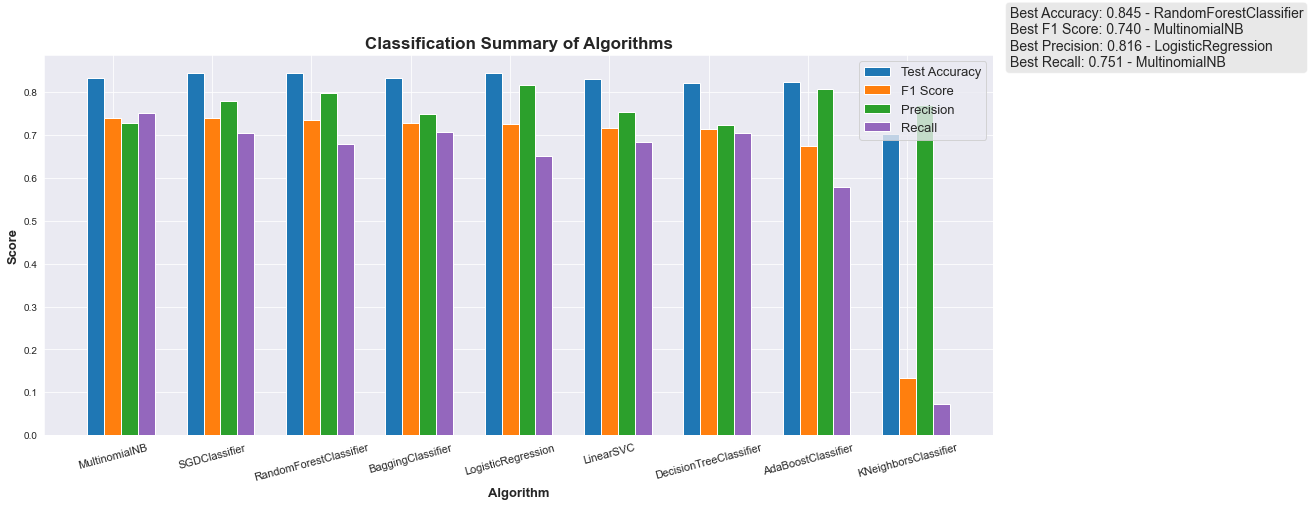

In [34]:
sns.set_style('darkgrid')
plt.figure(figsize = (17, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Accuracy: Test']
bars2 = results['F1 Score: Test']
bars3 = results['Precision: Test']
bars4 = results['Recall: Test']

 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

 
# Make the plot
pal = sns.color_palette()
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Test Accuracy')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='F1 Score')
plt.bar(r3, bars3, color= pal[2], width=barWidth, edgecolor='white', label='Precision')
plt.bar(r4, bars4, color= pal[4], width=barWidth, edgecolor='white', label='Recall')

 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Score', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(['Best Accuracy: {:.3f} - {}'.format(best_acc['Accuracy: Test'].values[0], best_acc['Algorithm'].values[0]), 
                     'Best F1 Score: {:.3f} - {}'.format(best_f1['F1 Score: Test'].values[0], best_f1['Algorithm'].values[0]),
                   'Best Precision: {:.3f} - {}'.format(best_precision['Precision: Test'].values[0], best_precision['Algorithm'].values[0]), 
                    'Best Recall: {:.3f} - {}'.format(best_recall['Recall: Test'].values[0], best_recall['Algorithm'].values[0])])
props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9.2, 1, textstr, fontsize=14,
        verticalalignment='top', bbox=props)

plt.title('Classification Summary of Algorithms', fontweight = 'bold', fontsize = 17);

In [35]:
# store the best/worst performance time
best_train_time = results[results['Training Time'] == results['Training Time'].min()]
worst_train_time = results[results['Training Time'] == results['Training Time'].max()]
best_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].min()]
worst_prediction_time = results[results['Prediction Time'] == results['Prediction Time'].max()]

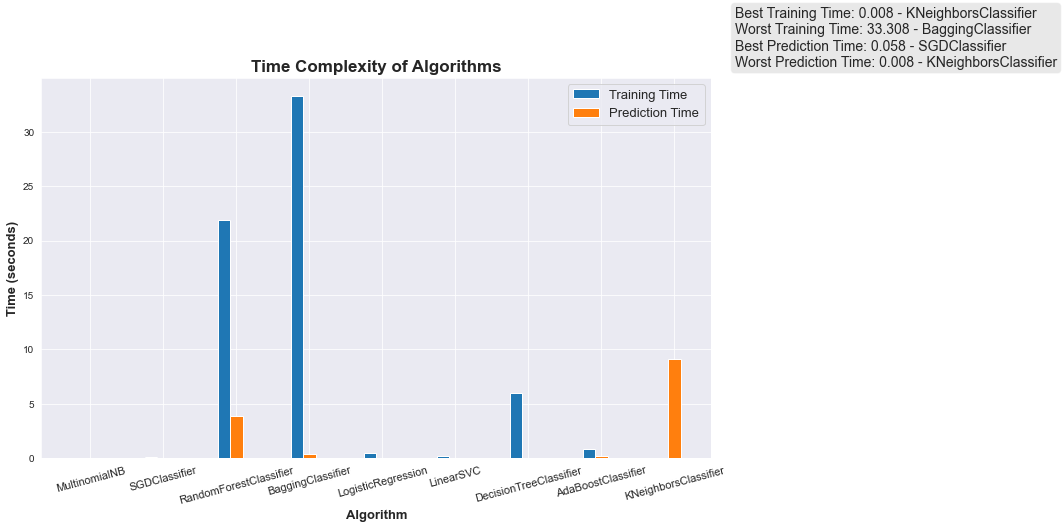

In [36]:
plt.figure(figsize = (12, 7))

barWidth = 0.17
 
# set height of bar
bars1 = results['Training Time']
bars2 = results['Prediction Time']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.bar(r1, bars1, color= pal[0], width=barWidth, edgecolor='white', label='Training Time')
plt.bar(r2, bars2, color= pal[1], width=barWidth, edgecolor='white', label='Prediction Time')
 
# Add xticks on the middle of the group bars
plt.xlabel('Algorithm', fontweight='bold', fontsize = 13)
plt.ylabel('Time (seconds)', fontweight = 'bold', fontsize = 13)
plt.xticks([r + barWidth for r in range(len(bars1))], results['Algorithm'], rotation = 15, fontsize = 11)
 
# Create legend & Show graphic
plt.legend(fontsize = 13)

textstr = '\n'.join(('Best Training Time: {:.3f} - {}'.format(best_train_time['Training Time'].values[0], best_train_time['Algorithm'].values[0]), 
                     'Worst Training Time: {:.3f} - {}'.format(worst_train_time['Training Time'].values[0], worst_train_time['Algorithm'].values[0]),
                   'Best Prediction Time: {:.3f} - {}'.format(best_prediction_time['Training Time'].values[0], best_prediction_time['Algorithm'].values[0]), 
                    'Worst Prediction Time: {:.3f} - {}'.format(worst_prediction_time['Training Time'].values[0], worst_prediction_time['Algorithm'].values[0])))

props = dict(boxstyle='round', facecolor='lightgrey', alpha=0.5)

#place a text box
plt.text(9, 36, textstr, fontsize=14,  bbox=props)

plt.title('Time Complexity of Algorithms', fontweight = 'bold', fontsize = 17);

The Algorithms MultinomialNB, SGD, Logistic Regression and AdaBoost and LinearSVC have more or less similar performance. We will tune the hyperparameters of these algorithms. However, the training time for Bagging is very high as compared to the others. Hence we drop it.

### Tuning Hyperparameters 

In [37]:
def param_tuning(clf, param_dict, X_train, y_train, X_test, y_test):
    
    # make scorer object
    scorer = make_scorer(f1_score)

    # perform Grid Search for Parameters
    grid_obj = GridSearchCV(estimator = clf,
                           param_grid = param_dict,
                           scoring = scorer,
                           cv = 5)

    grid_fit = grid_obj.fit(X_train, y_train)

    # Get the estimator
    best_clf = grid_fit.best_estimator_

    # Make predictions using the unoptimized and model
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    best_predictions = best_clf.predict(X_test)
    
    # Report the before-and-afterscores
    print(clf.__class__.__name__)
    print("\nOptimized Model\n------")
    print("Best Parameters: {}".format(grid_fit.best_params_))
    print("Accuracy: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("F1-score: {:.4f}".format(f1_score(y_test, best_predictions)))
    print("Precision: {:.4f}".format(precision_score(y_test, best_predictions)))
    print("Recall: {:.4f}".format(recall_score(y_test, best_predictions)))

###   Stochastic Gradient Classifier:

In [38]:
# Dict for parameters
param_grid = {
    'alpha' : [0.095, 0.0002, 0.0003],
    'max_iter' : [2500, 3000, 4000]
}

clf_sgd = SGDClassifier()

param_tuning(clf_sgd, param_grid, training_data, y_train, testing_data, y_test)

SGDClassifier

Optimized Model
------
Best Parameters: {'alpha': 0.0003, 'max_iter': 3000}
Accuracy: 0.8502
F1-score: 0.7363
Precision: 0.8234
Recall: 0.6659


### Logistic Regression Classifier: 

In [39]:
# Dict for parameters
param_grid = {
    'C': [1, 1.2, 1.3, 1.4]
}

clf_lr = LogisticRegression()

param_tuning(clf_lr, param_grid, training_data, y_train, testing_data, y_test)

LogisticRegression

Optimized Model
------
Best Parameters: {'C': 1.4}
Accuracy: 0.8459
F1-score: 0.7295
Precision: 0.8132
Recall: 0.6614


### Decision Tree Classifier: 

In [40]:
param_grid = {
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 5, 8]
}

clf_dt = DecisionTreeClassifier()

param_tuning(clf_dt, param_grid, training_data, y_train, testing_data, y_test)

DecisionTreeClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.8269
F1-score: 0.7176
Precision: 0.7361
Recall: 0.6999


### Random Forest Classifier: 

In [41]:
param_grid = {
    'n_estimators': [50,150],
    'min_samples_leaf': [1, 5],
    'min_samples_split': [2, 5]
}

clf_rf = RandomForestClassifier()

param_tuning(clf_rf, param_grid, training_data, y_train, testing_data, y_test)

RandomForestClassifier

Optimized Model
------
Best Parameters: {'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Accuracy: 0.8509
F1-score: 0.7462
Precision: 0.8019
Recall: 0.6977


### Linear SVC: 

In [43]:
param_grid = {
    'C': [0.25, 0.5, 0.75, 1, 1.2]
}

clf_linsvc = LinearSVC()

param_tuning(clf_linsvc, param_grid, training_data, y_train, testing_data, y_test)

LinearSVC

Optimized Model
------
Best Parameters: {'C': 0.25}
Accuracy: 0.8469
F1-score: 0.7362
Precision: 0.8021
Recall: 0.6803


In [49]:
MultinomialNB().get_params().keys()

dict_keys(['alpha', 'class_prior', 'fit_prior'])

### Multinomial NB

In [50]:
#param_grid = {'var_smoothing': np.<a onclick="parent.postMessage({'referent':'.numpy.logspace'}
    
#param_grid_nb = {
#    'var_smoothing': np.logspace(0,-9, num=100)
#}

alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
p_grid_NB = {'alpha': alphas, 'fit_prior' : [True, False], 'class_prior' : [None, [.1,.9],[.2, .8]]}


clf_mnb = MultinomialNB()
param_tuning(clf_mnb, p_grid_NB, training_data, y_train, testing_data, y_test)

MultinomialNB

Optimized Model
------
Best Parameters: {'alpha': 1.0, 'class_prior': None, 'fit_prior': True}
Accuracy: 0.8340
F1-score: 0.7399
Precision: 0.7287
Recall: 0.7513


### Conclusion: 

We found Stochastic Gradient Classifier & MultinomialNB have better F1-scores compared to the rest of the models in terms of training & testing time etc. However, based on other evaluation metrics Stochastic Gradient Classifier is the best suited model for our data. We achieved the following performance parameters:

F1-Score: 73.63 %
Accuracy: 85.02 %
Precision: 82.34 %
Recall: 66.59 %

In [51]:
filename = 'cb_rf_final.sav'  #Save the model
joblib.dump(clf_rf, filename)

['cb_rf_final.sav']